In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import xarray as xr
# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
import pickle

In [2]:
infile = open('../river_sources.pkl', 'rb')
river_sources = pickle.load(infile)

In [3]:
data = xr.open_dataset('../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc')

In [4]:
data['time']

<xarray.DataArray 'time' (time: 1)>
array(['2018-01-01T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T12:00:00
Attributes:
    long_name:      Time (hours since 1950-01-01)
    standard_name:  time
    valid_min:      596100.0
    valid_max:      596100.0
    axis:           T

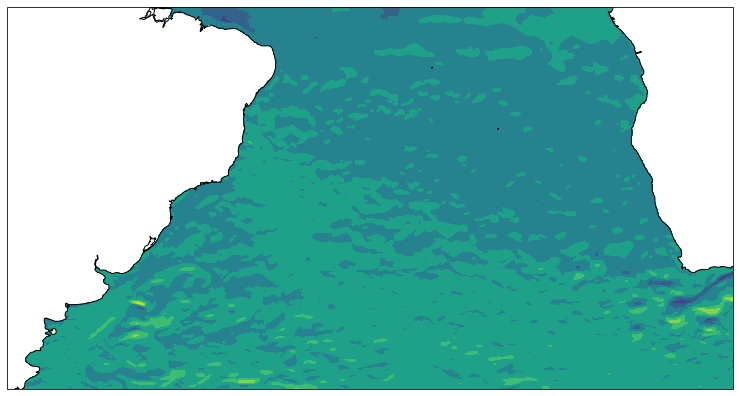

In [5]:
fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
plt.contourf(data['longitude'], data['latitude'], data['uo'][0,0],
             transform=ccrs.PlateCarree())

ax.coastlines()

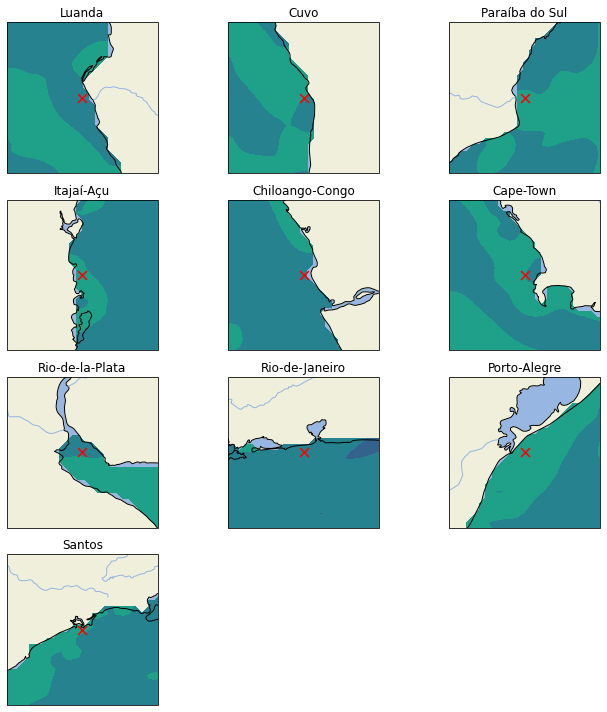

In [8]:
fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(10,10),
                      subplot_kw={'projection': ccrs.PlateCarree()})
r = 1
i = 0
for k, loc in enumerate(river_sources):
    j = k%3
    lat_BA, lon_BA = river_sources[loc]
    
    ax[i,j].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i,j].add_feature(cfeature.OCEAN)
    ax[i,j].add_feature(cfeature.LAND)
    ax[i,j].add_feature(cfeature.COASTLINE)
    ax[i,j].add_feature(cfeature.RIVERS)
    ax[i,j].set_title(loc)
    
    ax[i,j].contourf(data['longitude'], data['latitude'], data['uo'][0,0],
             transform=ccrs.PlateCarree())
    ax[i,j].scatter(lon_BA, lat_BA, s=80, marker='x', color='red')
    if j%3 == 2: i+=1 

plt.tight_layout()

ax[3,1].remove()
ax[3,2].remove()

In [9]:
lat_range = slice(1, 900)
lon_range = slice(1284, 2460)

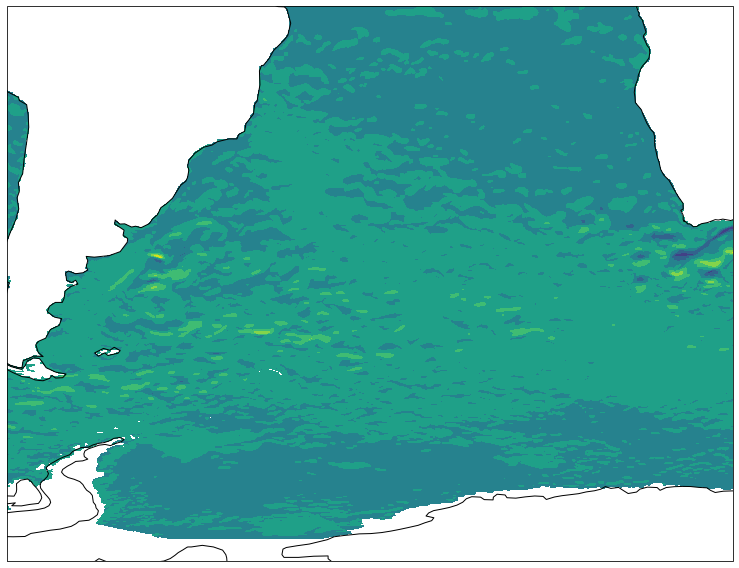

In [12]:
fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
plt.contourf(data['longitude'][lon_range], data['latitude'][lat_range], data['uo'][0,0,lat_range, lon_range],
             transform=ccrs.PlateCarree())

ax.coastlines()

In [13]:
particles = xr.load_dataset('../data/test1month.nc')
particles

<xarray.Dataset>
Dimensions:     (obs: 361, traj: 10000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 1e+04 1e+04 1e+04 ... 2e+04 2e+04 2e+04
    time        (traj, obs) datetime64[ns] 2018-01-01T12:00:00 ... 2018-01-31...
    lat         (traj, obs) float32 -9.289656 -9.279032 ... -23.763296
    lon         (traj, obs) float32 13.002034 12.999578 ... -45.448166
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev292+gc6c2d7bb
    parcels_mesh:           spherical

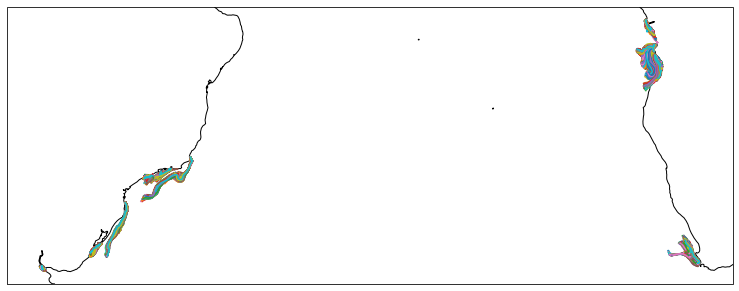

In [15]:
fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
# ax.contourf(data['longitude'][lon_range], data['latitude'][lat_range], data['uo'][0,0,lat_range, lon_range],
#              transform=ccrs.PlateCarree())

ax.coastlines()
ax.plot(particles['lon'].T, particles['lat'].T);